In [1]:
import pandas as pd
import numpy as np
import umap
import hdbscan

import warnings
warnings.filterwarnings("ignore")



pd.set_option('display.max_rows', 100)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 100)  # Auto-detect the display width
pd.set_option('display.max_colwidth', 100)  # Show full content of each cell


C:\Users\F1302\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("distinct_posts_with_text.csv", sep=",", encoding="utf-8")
df.head()

,post_importation_id,post_platform,post_id,post_type,pf_post_id,post_created_at,post_is_deduced,post_lang,post_url,account_id,pf_account_id,account_name,screen_name,description,account_lang,account_url,document_id,document_text,document_text_fr,document_text_en,document_lang,account_registered_at,account_profile_picture,account_followers,account_following,account_posts,account_views,engagements,reactions,comments,shares,views,quotes,citations,repartages
0,622,Twitter,5950190,post,155204550754697216,2012-01-06 08:30:23,False,fr,https://twitter.com/i/web/status/155204550754697216,2033581,99747172,philippe casquero,casqueroart,artiste peintre plasticien,NaN,https://twitter.com/casqueroart,8470122,"PERPIGNAN:Clotilde Ripoull,conseillère municipale d’opposition,dénonce « la pub du maire aux fra...","PERPIGNAN:Clotilde Ripoull,conseillère municipale d’opposition,dénonce « la pub du maire aux fra...",NaN,NaN,2009-12-27 17:31:27,https://pbs.twimg.com/profile_images/560304123216543744/efU2TsIK_normal.jpeg,308,881,1441,0,0,0,0,0,0,0,0,0
1,622,Twitter,5950191,post,158947882207154176,2012-01-16 16:25:02,False,fr,https://twitter.com/i/web/status/158947882207154176,2033582,271927894,CorpoDroit Perpignan,corpodroitperpi,Corpo Dret - Universitat Perpinyà Via Domitia,NaN,https://twitter.com/corpodroitperpi,8470124,"Cette année, la Corpo présentera une liste pour les élections aux conseil d'UFR SJE ! Celles-ci ...","Cette année, la Corpo présentera une liste pour les élections aux conseil d'UFR SJE ! Celles-ci ...",NaN,NaN,2011-03-25 13:21:19,https://pbs.twimg.com/profile_images/2153999367/Design_pin_s_final_normal.jpg,158,67,82,0,0,0,0,0,0,0,0,0
2,622,Twitter,5950192,post,162690472328966144,2012-01-27 00:16:45,False,fr,https://twitter.com/i/web/status/162690472328966144,2033583,213826152,ajouter rss,ajouterrss,Annuaire generaliste de Flux RSS libre. Soumettez gratuitement votre site Internet et Flux RSS s...,NaN,https://twitter.com/ajouterrss,8470126,Commissaire de quartiers de Perpignan: Presentation de l ordre informations sur la police munic...,Commissaire de quartiers de Perpignan: Presentation de l ordre informations sur la police munic...,NaN,NaN,2010-11-09 22:05:57,https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png,47,0,75915,0,0,0,0,0,0,0,0,0
3,622,Twitter,5950193,post,163720388663185408,2012-01-29 20:29:17,False,fr,https://twitter.com/i/web/status/163720388663185408,2033584,321234473,Election France,election_fr,NaN,NaN,https://twitter.com/election_fr,8470128,"A Perpignan, Marine Le Pen rappelle le ""rêve du ‘Travailler plus …: | 29… #election","A Perpignan, Marine Le Pen rappelle le ""rêve du ‘Travailler plus …: | 29… #election",NaN,NaN,2011-06-21 07:17:09,https://pbs.twimg.com/profile_images/1405911001/image_normal.jpg,196,0,12399,0,0,0,0,0,0,0,0,0
4,622,Twitter,5950194,post,163720380329115648,2012-01-29 20:29:15,False,fr,https://twitter.com/i/web/status/163720380329115648,2033584,321234473,Election France,election_fr,NaN,NaN,https://twitter.com/election_fr,8470131,"A Perpignan, Marine Le Pen rappelle le ""rêve du ‘Travailler plus …: | 29.01… #2012","A Perpignan, Marine Le Pen rappelle le ""rêve du ‘Travailler plus …: | 29.01… #2012",NaN,NaN,2011-06-21 07:17:09,https://pbs.twimg.com/profile_images/1405911001/image_normal.jpg,196,0,12399,0,0,0,0,0,0,0,0,0


# Pipeline NLP - Spacy

In [4]:
%%time
import re
from tqdm import tqdm
import emoji
import spacy
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def load_spacy_model(model: str) -> spacy.language.Language:
    """
    Load a spaCy model with optional configurations.

    Args:
        model : str
            Name of the spaCy model to load.

    Returns:
        nlp : spacy.language.Language
            Loaded spaCy language processing pipeline.

    """
    if torch.cuda.is_available():
        spacy.prefer_gpu()

    nlp = spacy.load(model)

    return nlp

def clean_text(text: str) -> str:
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"\s+", " ", text)  # Normalize whitespace
    text = text.strip()  # Remove leading/trailing spaces
    return text

def spacy_NER(nlp, df: pd.DataFrame, col_text: str, entities_to_keep: list = ['PERSON','ORG', 'LOC'], explode: bool = True, batch_size : int = 1000, n_process: int =8) -> pd.DataFrame:
    """
    Spacy implementation of NER.
    To define entities type to keep, call get_labels(nlp, pipe_step="ner", explanations=False)
    explode = False means it returns 1 list of entities per document
    explode = True means it returns 1 entity per row

    Args:
        nlp : spacy.language.Language
            The spaCy language processing pipeline.
        df : pd.DataFrame
            DataFrame containing the text data.
        col_text : str
            The name of the column containing the text data.
        entities_to_keep : list, optional
            List of entity types to keep. Default is ['PERSON','ORG', 'LOC'].
        batch_size : int, optional
            Batch sizes
        n_process : int, optional
            Number of processes

    Returns:
        pd.DataFrame
            DataFrame containing the NER information.

    Description:
        This function performs Named Entity Recognition (NER) using spaCy on a DataFrame with text data. It extracts entities of the specified types
        and stores the NER information in separate columns.
    """
    df[col_text] = df[col_text].apply(clean_text)
    l_text = df[col_text].tolist()
    all_records = []
    for doc in tqdm(nlp.pipe(l_text, batch_size=batch_size, n_process=n_process), total= len(l_text), desc = "NLP Process"):
        NER_type = []
        NER_text = []

        if len(entities_to_keep)>0:
            for ent in doc.ents:
                if ent.label_ in entities_to_keep:
                    NER_type.append(ent.label_)
                    NER_text.append(ent.text)
        else:
            for ent in doc.ents:
                NER_type.append(ent.label_)
                NER_text.append(ent.text)
        record = (NER_type, NER_text)
        all_records.append(record)

    df[['NER_type', 'NER_text']] = pd.DataFrame(all_records, index=df.index)

    return df


def generate_wordcloud(df: pd.DataFrame,
                       col_word: str,
                       col_metric: str,
                       width: int = 1500,
                       height: int = 750,
                       dpi: int = 72,
                       background_color: str = 'white',
                       show: bool = False) -> WordCloud:
    """
    Generate a word cloud from a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing word frequency data.
        col_word (str): Column name containing words.
        col_metric (str): Column name containing frequency metrics for each word.
        width (int, optional): Width of the word cloud image. Defaults to 3000.
        height (int, optional): Height of the word cloud image. Defaults to 1500.
        dpi (int, optional): Dots per inch for image resolution. Defaults to 300.
        background_color (str, optional): Background color of the word cloud image. Defaults to 'white'.
        show (bool, optional): Whether to display the word cloud image. Defaults to False.

    Returns:
        WordCloud: WordCloud object representing the generated word cloud.
    """

    top_n_words={row[col_word]:row[col_metric] for i,row in df.iterrows()}
    # top_n_words = dict(zip(df.col_word, df.col_metric)) ## plus optmisé

    # Generate a wordcloud of the top n words
    wordcloud = WordCloud(width=width, height=height, background_color=background_color, prefer_horizontal=1).generate_from_frequencies(top_n_words)
    if show :
        plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    return wordcloud



# on charge notre modèle
nlp = load_spacy_model("fr_core_news_lg")

# on affiche les labels disponibles pour le modèle chargé et la fonction linguistique visée
pipe_details = nlp.get_pipe("ner")
labels=list(pipe_details.labels)
print(labels)

['LOC', 'MISC', 'ORG', 'PER']
CPU times: total: 11.7 s
Wall time: 13.1 s


NLP Process: 100%|██████████| 12263/12263 [00:40<00:00, 299.62it/s]


LOC


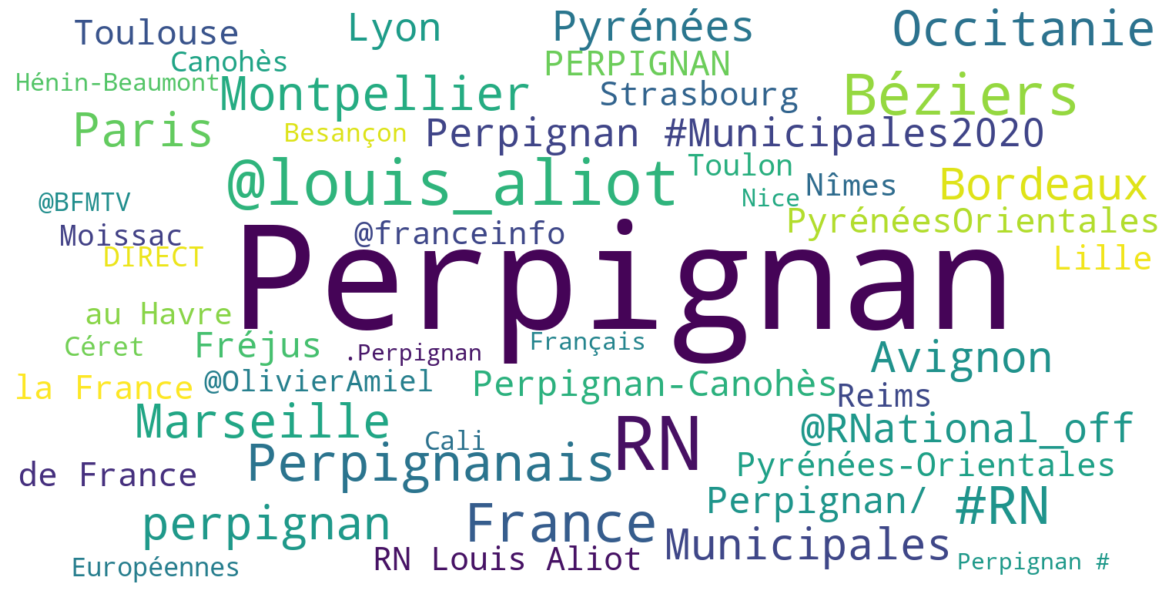





MISC


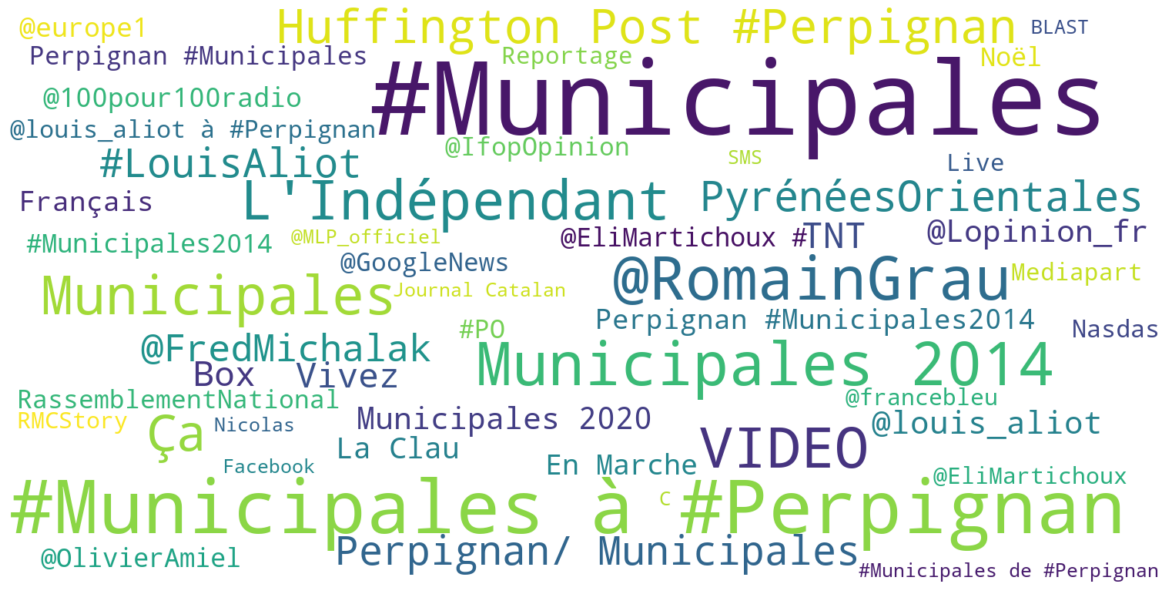





ORG


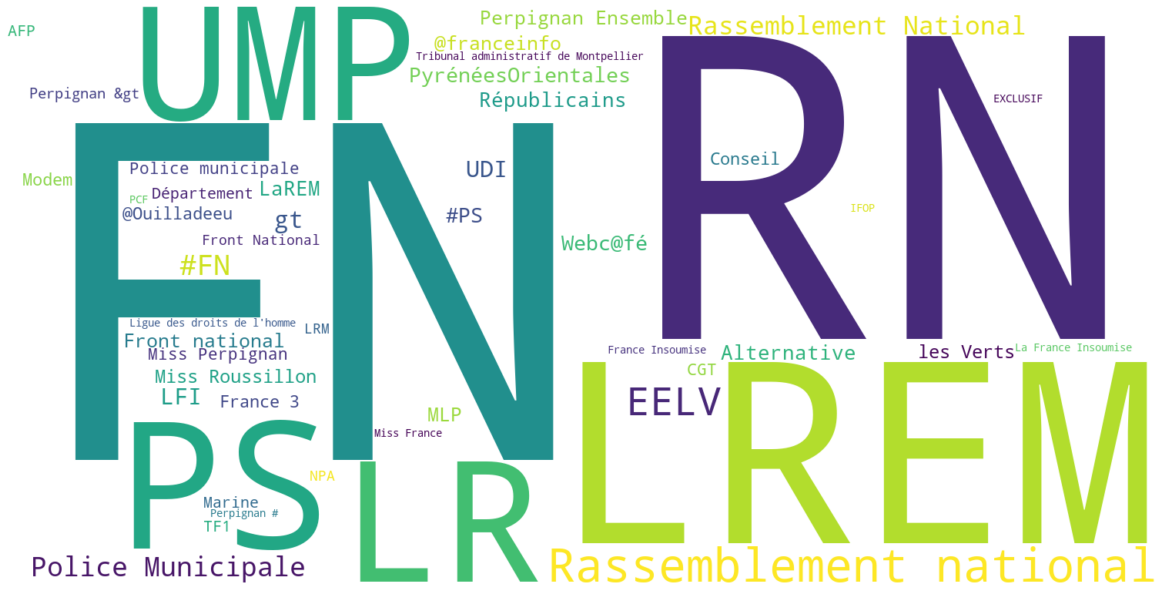





PER


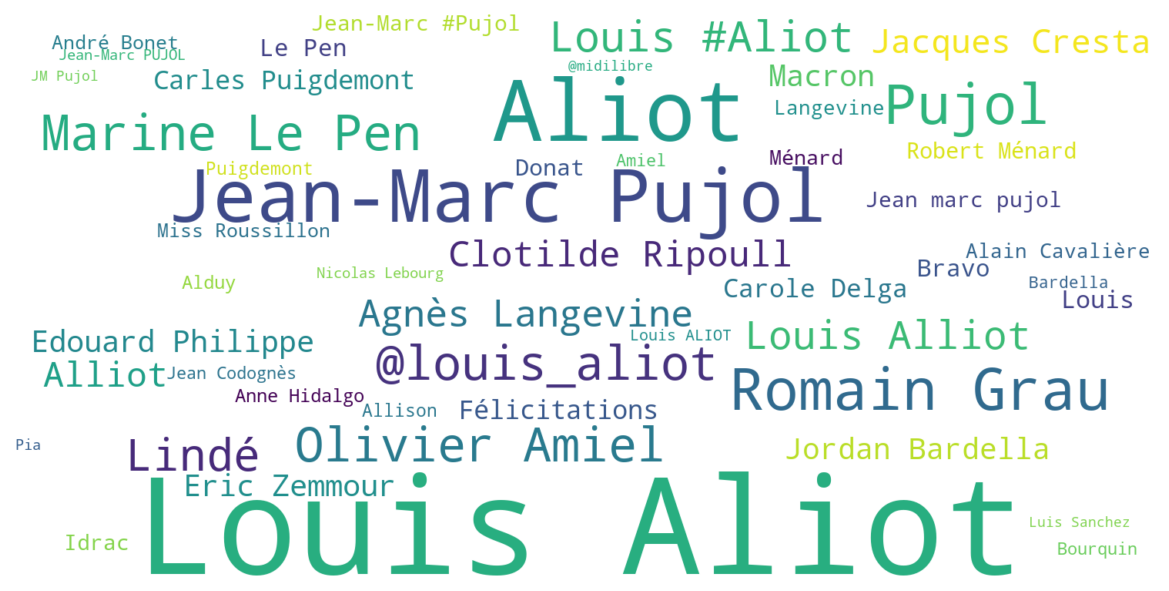





CPU times: total: 45.7 s
Wall time: 46.2 s


In [37]:
%%time
# Ici on sélectionne le type d'entités nommées à détecter
entity_labels = ['LOC', 'ORG', 'PER']


# on utilise la fonction de détection d'entitées nommées
df = spacy_NER(nlp, df, "document_text_fr", entities_to_keep = [], batch_size = 512, n_process = 1)

# on crée un nouveau dataframe où 1 ligne = 1 entitée
df_entities = df.copy()
df_entities = df_entities[df_entities['NER_type'].apply(lambda x: len(x) > 0)]
df_entities = df_entities.explode(['NER_type', 'NER_text'])

# on affiche les entitées les plus fréquemment citées
for NER_type in labels:
  df_top_entities = (
                      df_entities[df_entities['NER_type']== NER_type].groupby(['NER_text', 'NER_type'])
                      .agg({"post_id":'nunique'})
                      .sort_values(by="post_id", ascending=False)
                      .reset_index()
                    )
  print(NER_type)
  generate_wordcloud(df_top_entities.head(50), "NER_text", "post_id", show = True)
  print('\n'*3)

# Lemmatisation

In [6]:
from spacy.lang.fr.stop_words import STOP_WORDS as sw


In [8]:
# Lemmatisation
for i in sw:
  _ = nlp(i)
  for ent in _.ents:
    if ent.label_ in labels:
      print(i, ent.label_)

aupres LOC
tiennes LOC
vôtre LOC
hue PER
nôtres LOC
prealable PER
basee ORG
da LOC
anterieure LOC
malgre LOC
voila PER
moindres LOC
mienne LOC
revoila LOC
vôtres LOC
etais LOC
vas MISC
dejà MISC
elles-memes MISC
apres LOC
ouste PER
hem PER
hep MISC
ça MISC
ouias PER
houp PER
memes LOC
vé PER


In [10]:
df.document_text_fr[df.document_text_fr.apply(lambda x : ("\t") in x)].values

array([], dtype=object)

In [11]:
%%time 

def clean_text(text: str) -> str:
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"\s+", " ", text)  # Normalize whitespace
    text = text.strip()
    text = text.lower()  # Remove leading/trailing spaces
    return text

def lemmatization(nlp, df: pd.DataFrame, col_text: str, col_lemma: str, pos_to_keep: list = [], stopwords: list = sw, batch_size: int = 512, n_process: int = 1, join_list: bool = False) -> pd.DataFrame:
    """
    Perform natural language processing tasks using spaCy : tokenization, PoS Tagging and lemmatization

    Args:
        nlp : spacy.Language
            The spaCy language model.
        df : pandas.DataFrame
            The DataFrame containing the text data.
        col_text : str
            The name of the column containing the text data.
        col_lemma : str
            The name of the column to store the lemmatized text data.
        pos_to_keep : list
            A list of part-of-speech tags to keep during lemmatization.
        stopwords : list
            A list of stopwords to remove during processing.
        batch_size : int, optional
            The batch size for spaCy processing. Default is 100.
        n_process : int, optional
            The number of processes for parallel processing. Default is 1.
        join_list : bool, optional
            Whether to join the lemmas into a single string. Default is False.

    Returns:
        pandas.DataFrame
            The DataFrame with processed text data.

    """

    df[col_text] = df[col_text].apply(clean_text)

    all_lemmas=[]
    
    text=list(df[col_text].astype('unicode').values)

    for doc in tqdm(nlp.pipe(text, batch_size=batch_size, n_process=n_process), total= len(text), desc = "NLP Process"):

# garde uniquement les mots pertinents, flitre
        if len(pos_to_keep)>0 and len(stopwords)>0:
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space) and tok.text.lower() not in stopwords and tok.pos_ in pos_to_keep]
        elif len(pos_to_keep)>0 and len(stopwords) < 1:
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space) and tok.pos_ in pos_to_keep]
        elif len(pos_to_keep) < 1 and len(stopwords) > 0:
            lemmas_list = [str(tok.lemma_) for tok in doc if not (tok.is_punct or tok.is_space) and tok.text.lower() not in stopwords ]
        else :
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space)]

        all_lemmas.append(lemmas_list)

    if join_list:
        df[col_lemma]=[' '.join(map(str, l)) for l in all_lemmas]
    else:
        df[col_lemma]=all_lemmas

    return df

# toujours à l'aide de notre modèle spacy, on lemmatise le texte en ne conservant que certains PoS tags

df = lemmatization(nlp, df, "document_text_fr", "lemmatized_text", pos_to_keep=[], stopwords = list(sw), batch_size = 512, n_process = 1, join_list = True)
print(df["lemmatized_text"])

NLP Process: 100%|██████████| 12263/12263 [00:53<00:00, 229.70it/s]

0            perpignan clotilde ripoull conseiller municipal opposition dénoncer pub maire frais perpignanai
1                                              année corpo présenter liste élection conseil ufr sje dérouler
2                           commissaire quartier perpignan presentation l ordre information police municipal
3                                                perpignan marine pen rappeler rêve travailler | 29 election
4                                                 perpignan marine pen rappeler rêve travailler | 29.01 2012
                                                        ...                                                 
12258    marine pen risque peine inéligibilité exécution provisoire pouvoir présenter élection présidenti...
12259    19 juin débuter tribunal perpignan procès maire barcarè alain ferrand prise illégal intérêt cas ...
12260                                           procès rn louis aliot zone turbulence an municipal perpignan
12261    abstention

# Sampling


In [14]:
df_sample = df[~df["document_text_fr"].duplicated()]
print(df_sample.shape)
df_not_sample =  df[~df['post_id'].isin(df_sample['post_id'])]
df_not_sample.shape


(11087, 36)


(1176, 36)

# Topic Modeling - Etape n°1 - Vectorisation

On va transformer nos textes en vecteurs ("embeddings") à l'aide d'un modèle pré-entrainé de type "SentenceTransformer".


In [ ]:
# Fast and efficient model for French (multilingual-MiniLM)
from sentence_transformers import SentenceTransformer
model_fast_fr = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Encode the French texts
sample_embeddings_fast_fr = model_fast_fr.encode(list(df_sample['sentences']))
not_sample_embeddings_fast_fr = model_fast_fr.encode(list(df_not_sample['sentences']))
print(f"Fast French model embeddings shape: {sample_embeddings_fast_fr.shape}")


In [ ]:
# Higher quality French model
from sentence_transformers import SentenceTransformer
model_quality_fr = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")
# Encode the French texts
sample_embeddings_quality_fr = model_quality_fr.encode(list(df_sample['sentences']))
not_sample_embeddings_quality_fr = model_quality_fr.encode(list(df_not_sample['sentences']))
print(f"Quality French model embeddings shape: {sample_embeddings_quality_fr.shape}")

In [ ]:
# Basic/slower model for French (less effective)
from sentence_transformers import SentenceTransformer
model_basic_fr = SentenceTransformer("distiluse-base-multilingual-cased-v1")
# Encode the French texts
sample_embeddings_basic_fr = model_basic_fr.encode(list(df_sample['sentences']))
not_sample_embeddings_basic_fr = model_basic_fr.encode(list(df_not_sample['sentences']))
print(f"Basic French model embeddings shape: {sample_embeddings_basic_fr.shape}")

# Etape n°2 - Réduction de dimensions
Chaque texte est désormais représenté par un vecteur en 300, à 800 dimensions. On va effectuer une réduction de dimensions pour

*   facilement représenter le résultat en 2 ou 3 dimensions
*   limiter les calculs
* s'intéresser aux dimensions les plus "significatives"


## Fast model (Erwan)

In [ ]:
%%time
import umap
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat  # !!!!!!!!!!!!!!!!!

parameters = {"n_neighbors": 15,
              "n_components": 2,
              "min_dist": 0.1,
              "metric": "cosine",
              "spread": 0.8,
              "random_state": 42,
              "n_epochs": 1000,
              "learning_rate": 0.01
             }

# Fit the UMAP model on your embeddings
reducer = umap.UMAP(**parameters).fit(sample_embeddings_fast_fr)

# Transform the embeddings to 2D
sample_reduced_embeddings = reducer.transform(sample_embeddings_fast_fr)

# Print the shape of the reduced embeddings
print(f"Reduced embeddings shape: {sample_reduced_embeddings.shape}")

# Add the coordinates to your dataframe
df_sample['x'] = sample_reduced_embeddings[:,0]
df_sample['y'] = sample_reduced_embeddings[:,1]


# Create a matplotlib figure
plt.figure(figsize=(10, 10))
plt.scatter(df_sample['x'], df_sample['y'], alpha=0.5)
plt.title('UMAP Projection of Sentence Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [ ]:
# Transform not_sample embeddings using the same reducer
not_sample_reduced_embeddings = reducer.transform(not_sample_embeddings_fast_fr)

# Add the coordinates to the not_sample dataframe
df_not_sample['x'] = not_sample_reduced_embeddings[:,0]
df_not_sample['y'] = not_sample_reduced_embeddings[:,1]

# Add source column to distinguish between datasets
df_sample['source'] = 'sample'
df_not_sample['source'] = 'not_sample'

# Concatenate the dataframes
df_concat = pd.concat([df_sample, df_not_sample])

# Create the plot using matplotlib
plt.figure(figsize=(12, 12))

# Plot sample points
sample_data = df_concat[df_concat['source'] == 'sample']
plt.scatter(sample_data['x'], sample_data['y'], color='blue', alpha=0.6, label='Sample')

# Plot not_sample points
not_sample_data = df_concat[df_concat['source'] == 'not_sample']
plt.scatter(not_sample_data['x'], not_sample_data['y'], color='red', alpha=0.6, label='Not Sample')

# Add labels and legend
plt.title('UMAP Projection of Sentence Embeddings', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.show()

# Print some statistics
print(f"Number of sample points: {len(sample_data)}")
print(f"Number of not_sample points: {len(not_sample_data)}")


## Higher quality 

In [ ]:
%%time
import umap
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat  # !!!!!!!!!!!!!!!!!

parameters = {"n_neighbors": 15,
              "n_components": 2,
              "min_dist": 0.1,
              "metric": "cosine",
              "spread": 0.8,
              "random_state": 42,
              "n_epochs": 1000,
              "learning_rate": 0.01
             }

# Fit the UMAP model on your embeddings
reducer = umap.UMAP(**parameters).fit(sample_embeddings_quality_fr)

# Transform the embeddings to 2D
sample_reduced_embeddings = reducer.transform(sample_embeddings_quality_fr)

# Print the shape of the reduced embeddings
print(f"Reduced embeddings shape: {sample_reduced_embeddings.shape}")

# Add the coordinates to your dataframe
df_sample['x'] = sample_reduced_embeddings[:,0]
df_sample['y'] = sample_reduced_embeddings[:,1]


# Create a matplotlib figure
plt.figure(figsize=(10, 10))
plt.scatter(df_sample['x'], df_sample['y'], alpha=0.5)
plt.title('UMAP Projection of Sentence Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [ ]:
# Transform not_sample embeddings using the same reducer
not_sample_reduced_embeddings = reducer.transform(not_sample_embeddings_quality_fr)

# Add the coordinates to the not_sample dataframe
df_not_sample['x'] = not_sample_reduced_embeddings[:,0]
df_not_sample['y'] = not_sample_reduced_embeddings[:,1]

# Add source column to distinguish between datasets
df_sample['source'] = 'sample'
df_not_sample['source'] = 'not_sample'

# Concatenate the dataframes
df_concat = pd.concat([df_sample, df_not_sample])

# Create the plot using matplotlib
plt.figure(figsize=(12, 12))

# Plot sample points
sample_data = df_concat[df_concat['source'] == 'sample']
plt.scatter(sample_data['x'], sample_data['y'], color='blue', alpha=0.6, label='Sample')

# Plot not_sample points
not_sample_data = df_concat[df_concat['source'] == 'not_sample']
plt.scatter(not_sample_data['x'], not_sample_data['y'], color='red', alpha=0.6, label='Not Sample')

# Add labels and legend
plt.title('UMAP Projection of Sentence Embeddings', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.show()

# Print some statistics
print(f"Number of sample points: {len(sample_data)}")
print(f"Number of not_sample points: {len(not_sample_data)}")


## Simple model

In [ ]:
%%time
import umap
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat  # !!!!!!!!!!!!!!!!!

parameters = {"n_neighbors": 15,
              "n_components": 2,
              "min_dist": 0.1,
              "metric": "cosine",
              "spread": 0.8,
              "random_state": 42,
              "n_epochs": 1000,
              "learning_rate": 0.01
             }

# Fit the UMAP model on your embeddings
reducer = umap.UMAP(**parameters).fit(sample_embeddings_basic_fr)

# Transform the embeddings to 2D
sample_reduced_embeddings = reducer.transform(sample_embeddings_basic_fr)

# Print the shape of the reduced embeddings
print(f"Reduced embeddings shape: {sample_reduced_embeddings.shape}")

# Add the coordinates to your dataframe
df_sample['x'] = sample_reduced_embeddings[:,0]
df_sample['y'] = sample_reduced_embeddings[:,1]


# Create a matplotlib figure
plt.figure(figsize=(10, 10))
plt.scatter(df_sample['x'], df_sample['y'], alpha=0.5)
plt.title('UMAP Projection of Sentence Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [ ]:
# Transform not_sample embeddings using the same reducer
not_sample_reduced_embeddings = reducer.transform(not_sample_embeddings_basic_fr)

# Add the coordinates to the not_sample dataframe
df_not_sample['x'] = not_sample_reduced_embeddings[:,0]
df_not_sample['y'] = not_sample_reduced_embeddings[:,1]

# Add source column to distinguish between datasets
df_sample['source'] = 'sample'
df_not_sample['source'] = 'not_sample'

# Concatenate the dataframes
df_concat = pd.concat([df_sample, df_not_sample])

# Create the plot using matplotlib
plt.figure(figsize=(12, 12))

# Plot sample points
sample_data = df_concat[df_concat['source'] == 'sample']
plt.scatter(sample_data['x'], sample_data['y'], color='blue', alpha=0.6, label='Sample')

# Plot not_sample points
not_sample_data = df_concat[df_concat['source'] == 'not_sample']
plt.scatter(not_sample_data['x'], not_sample_data['y'], color='red', alpha=0.6, label='Not Sample')

# Add labels and legend
plt.title('UMAP Projection of Sentence Embeddings', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.show()

# Print some statistics
print(f"Number of sample points: {len(sample_data)}")
print(f"Number of not_sample points: {len(not_sample_data)}")
